In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    endword = []
    decorword = []
    condition = False
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'N':
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            else:
                nouns.append(word[0])
        elif word[1][:1] == 'M':
            decorword.append(word[0])
        elif word[1][-2:] == 'EC':
            endword.append(word[0])
            if (word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록')):
                condition = True
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            endword.append(word[0])
            ret.append((word[0], condition, nouns, endword, decorword))
            nouns = []
            condition = False
    if len(nouns) > 0:
        ret.append((word[0], condition, nouns, endword, decorword))
    return ret

In [4]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited = parse_sentence(item.text)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-22 16:36:12.137456 0
2019-12-22 16:36:53.606049 100000
2019-12-22 16:37:43.424403 200000


In [5]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [6]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')
wc.add_bucket('endword')
wc.add_bucket('decorword')

for normal in normals:
    for item in normal[:-1]:
        wc.add_list('endword', item[3])
        wc.add_list('decorword', item[4])
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-1]:
        wc.add_list('endword', item[3])
        wc.add_list('decorword', item[4])
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [7]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))
endword_df = pd.Series(wc.get_counts('endword'))
decorword_df = pd.Series(wc.get_counts('decorword'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]
endword_df = endword_df[endword_df.index.map(len) > 1]
decorword_df = decorword_df[decorword_df.index.map(len) > 1]

In [8]:
# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
#display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
#display(general_df[general_df > 500])
display(decorword_df[decorword_df > 5000])

많이      128212
모두       78086
함께      111463
가득      178524
오늘      107242
         ...  
결코        5627
똑똑        8126
당연히       7437
아무래도      9713
솔직히       6628
Length: 114, dtype: int64

In [9]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 150 + 50 
GENERAL_WORD_FTR_SIZE = 250 + 50
ENDWORD_WORD_FTR_SIZE = 150 + 50
DECORWORD_WORD_FTR_SIZE = 150 + 50

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)
endword_dic = list(endword_df.sort_values(ascending=False).head(ENDWORD_WORD_FTR_SIZE).index)
decorword_dic = list(decorword_df.sort_values(ascending=False).head(DECORWORD_WORD_FTR_SIZE).index)

In [10]:
#train_normal = []
#train_smishing = []
train_conditioned = []
train_general = []
train_endwords = []
train_decorwords = []

In [11]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    endwords = []
    decorwords = []
    for item in normal[:-1]:
        endwords += [x for x in item[3] if x in endword_dic]
        decorwords += [x for x in item[4] if x in decorword_dic]
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_endwords.append(list(endwords))
    train_decorwords.append(list(decorwords))
    original_idx.append(normal[-1])

In [12]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    endwords = []
    decorwords = []
    for item in smishing[:-1]:
        endwords += [x for x in item[3] if x in endword_dic]
        decorwords += [x for x in item[4] if x in decorword_dic]
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_endwords.append(list(endwords))
    train_decorwords.append(list(decorwords))
    original_idx.append(smishing[-1])

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_endwords = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_decorwords = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)
tidf_endwords = vectorizer_endwords.fit_transform(train_endwords)
tidf_decorwords = vectorizer_decorwords.fit_transform(train_decorwords)

In [14]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
tidf_endwords = np.array(tidf_endwords.toarray())
tidf_decorwords = np.array(tidf_decorwords.toarray())
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < 0.6]
tidf_cond_valid = tidf_conditioned[(split >= 0.6) & (split < 0.8)]
tidf_cond_test = tidf_conditioned[split >= 0.8]

tidf_gen_train = tidf_general[split < 0.6]
tidf_gen_valid = tidf_general[(split >= 0.6) & (split < 0.8)]
tidf_gen_test = tidf_general[split >= 0.8]

tidf_endw_train = tidf_endwords[split < 0.6]
tidf_endw_valid = tidf_endwords[(split >= 0.6) & (split < 0.8)]
tidf_endw_test = tidf_endwords[split >= 0.8]

tidf_decorw_train = tidf_decorwords[split < 0.6]
tidf_decorw_valid = tidf_decorwords[(split >= 0.6) & (split < 0.8)]
tidf_decorw_test = tidf_decorwords[split >= 0.8]

tidf_label_train = tidf_label[split < 0.6]
tidf_label_valid = tidf_label[(split >= 0.6) & (split < 0.8)]
tidf_label_test = tidf_label[split >= 0.8]

tidf_cond_train.shape, tidf_cond_valid.shape ,tidf_cond_test.shape

((177533, 200), (59281, 200), (59131, 200))

In [137]:
n_cond, n_gen, n_endw, n_decorw = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE, ENDWORD_WORD_FTR_SIZE, DECORWORD_WORD_FTR_SIZE
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
endw_input = keras.layers.Input(shape=(n_endw,), name='Endword')
decorw_input = keras.layers.Input(shape=(n_decorw,), name='Decorword')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_input, gen_input, endw_input, decorw_input])
concat_dropout_mlp = keras.layers.Dropout(0.2)(concat_mlp)

dense = keras.layers.Dense(32, name='FullyConnected-1')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.4, name='Dropout-1')(dense)

# dense_2 = keras.layers.Dense(64, name='FullyConnected-2')(dropout_1)
# dropout_2 = keras.layers.Dropout(0.4, name='Dropout-2')(dense_2)

dense_3 = keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l1(0.001), name='FullyConnected-3', activation='relu')(dropout_1)
dropout_3 = keras.layers.Dropout(0.4, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-4', activation='relu')(dropout_3)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, endw_input, decorw_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [138]:
tidf_label_valid.shape, sum(tidf_label_valid)

((59281,), 3724)

In [139]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_endw_train, tidf_decorw_train, tidf_label_train, normal_size=160, smishing_size=160):
        self.tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_endw_train_normal = tidf_endw_train[tidf_label_train == 0]
        self.tidf_decorw_train_normal = tidf_decorw_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.tidf_endw_train_smishing = tidf_endw_train[tidf_label_train == 1]
        self.tidf_decorw_train_smishing = tidf_decorw_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size)))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        np.random.seed(index)
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_endw_sample = self.tidf_endw_train_normal[normal_sampling]
        normal_decorw_sample = self.tidf_decorw_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_endw_sample = self.tidf_endw_train_normal[smishing_sampling]
        smishing_decorw_sample = self.tidf_decorw_train_normal[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_endw_train = np.concatenate([normal_endw_sample, smishing_endw_sample])
        sample_decorw_train = np.concatenate([normal_decorw_sample, smishing_decorw_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_endw_train, sample_decorw_train], sample_label_train

    def on_epoch_end(self):
        pass

In [140]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_endw_train, tidf_decorw_train, tidf_label_train, 320, 160)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_endw_valid, tidf_decorw_valid, tidf_label_valid, 8000, 500)

history = model.fit_generator(generator=train_gen,
                             epochs = 50,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 347
num_batch: 7
Epoch 1/50
347/347 [==============================] - 11s 31ms/step - loss: 0.6367 - binary_crossentropy: 0.5325 - acc: 0.8596 - val_loss: 0.4219 - val_binary_crossentropy: 0.3187 - val_acc: 0.9938
Epoch 2/50
347/347 [==============================] - 5s 13ms/step - loss: 0.2897 - binary_crossentropy: 0.1870 - acc: 0.9842 - val_loss: 0.1624 - val_binary_crossentropy: 0.0608 - val_acc: 0.9975
Epoch 3/50
347/347 [==============================] - 8s 22ms/step - loss: 0.1766 - binary_crossentropy: 0.0769 - acc: 0.9907 - val_loss: 0.1166 - val_binary_crossentropy: 0.0191 - val_acc: 0.9982
Epoch 4/50
347/347 [==============================] - 6s 19ms/step - loss: 0.1392 - binary_crossentropy: 0.0445 - acc: 0.9935 - val_loss: 0.1005 - val_binary_crossentropy: 0.0087 - val_acc: 0.9989
Epoch 5/50
347/347 [==============================] - 7s 20ms/step - loss: 0.1193 - binary_crossentropy: 0.0308 - acc: 0.9953 - val_loss: 0.0904 - val_binary_crossentropy: 0.0053 - va

347/347 [==============================] - 5s 13ms/step - loss: 0.0176 - binary_crossentropy: 0.0062 - acc: 0.9984 - val_loss: 0.0128 - val_binary_crossentropy: 0.0017 - val_acc: 0.9997
Epoch 43/50
347/347 [==============================] - 5s 15ms/step - loss: 0.0174 - binary_crossentropy: 0.0062 - acc: 0.9983 - val_loss: 0.0132 - val_binary_crossentropy: 0.0020 - val_acc: 0.9996
Epoch 44/50
347/347 [==============================] - 4s 11ms/step - loss: 0.0171 - binary_crossentropy: 0.0060 - acc: 0.9984 - val_loss: 0.0123 - val_binary_crossentropy: 0.0014 - val_acc: 0.9998
Epoch 45/50
347/347 [==============================] - 4s 11ms/step - loss: 0.0167 - binary_crossentropy: 0.0059 - acc: 0.9985 - val_loss: 0.0123 - val_binary_crossentropy: 0.0015 - val_acc: 0.9998
Epoch 46/50
347/347 [==============================] - 4s 12ms/step - loss: 0.0163 - binary_crossentropy: 0.0057 - acc: 0.9986 - val_loss: 0.0127 - val_binary_crossentropy: 0.0021 - val_acc: 0.9996
Epoch 47/50
347/347 [=

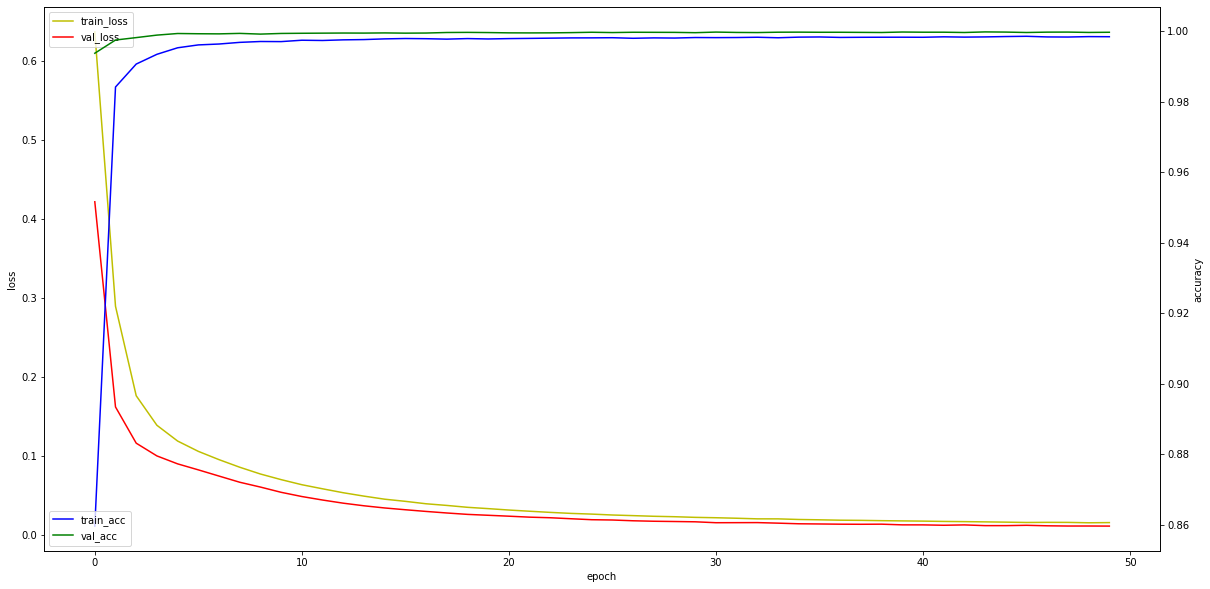

In [141]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [142]:
###### 결과검증(overfit, underfit)
gap_prev = gap
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, tidf_endw_test, tidf_decorw_test], batch_size=320)
gap = tidf_label_test - pred_test.reshape([-1,])

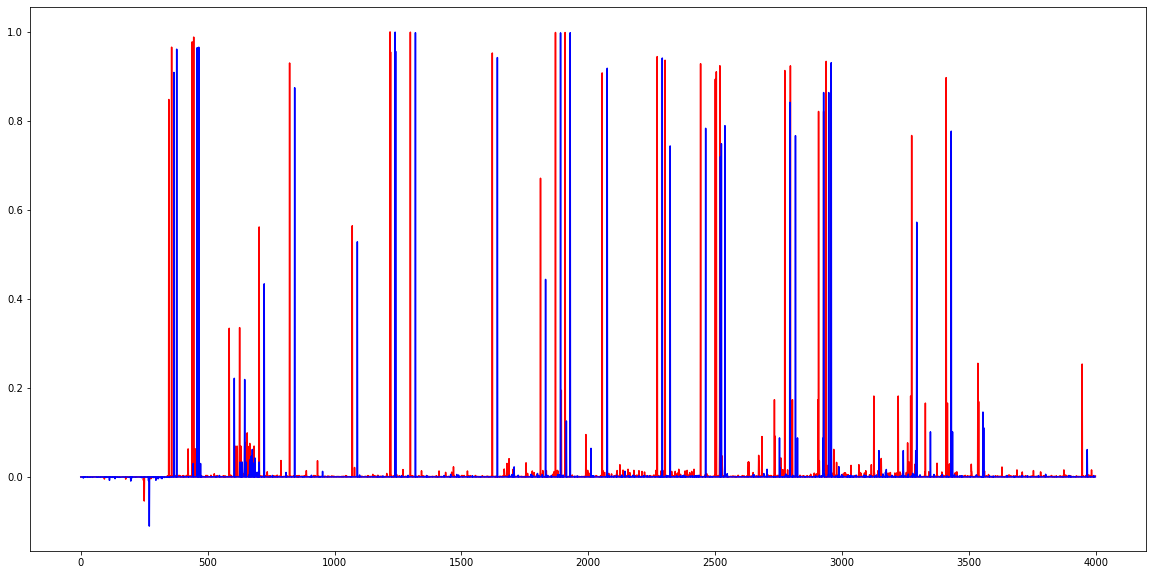

In [147]:
###### 결과검증(overfit, underfit)
#pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, tidf_endw_test, tidf_decorw_test], batch_size=320)
#gap = tidf_label_test - pred_test.reshape([-1,])
plt.figure(figsize=(20,10))
plt.plot(gap_prev[-4000:], 'r')
plt.plot(gap[-4020:-20], 'b')

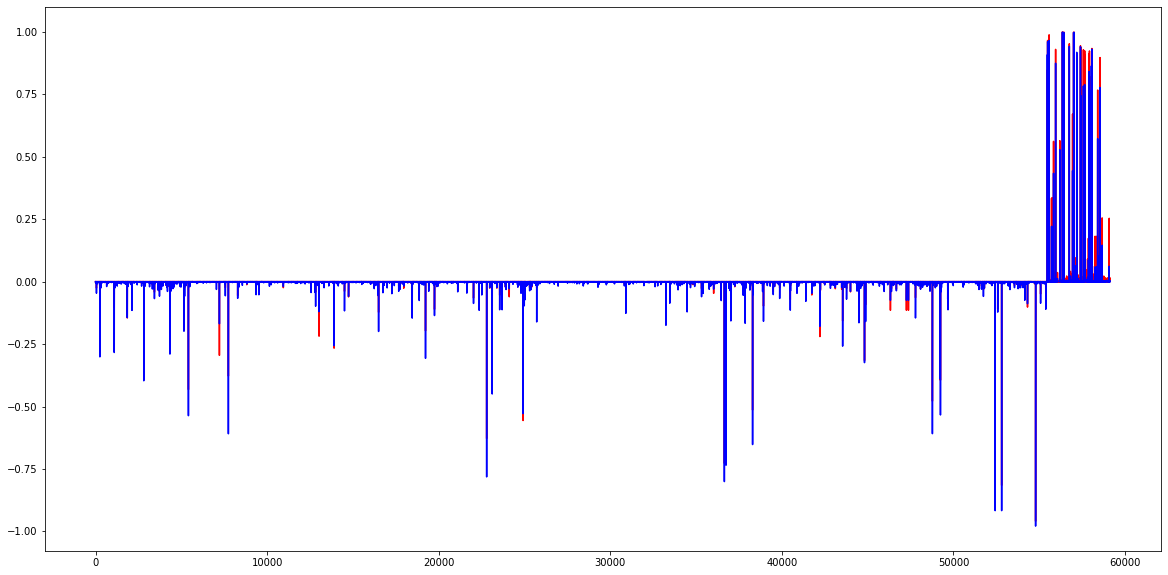

In [149]:
plt.figure(figsize=(20,10))
plt.plot(gap_prev, 'r')
plt.plot(gap, 'b')


auc : 0.9999496019827423


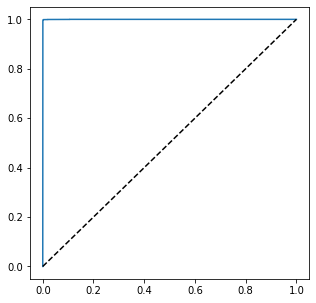

In [150]:
##### from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [44]:
0.9998961402861712 # best

0.9998961402861712

In [ ]:
df[df['id'].isin(np.array(original_idx)[split >= 0.8][gap > 0.5])].text.map(print)

In [ ]:
0.999886801482348  #  64 64 l1_0.0035, sigmoid A

In [ ]:
0.999870406857598 # 제출 (32, 32_l2_0.01, sigmoid, Adam_1e-4) ==> 93.0

In [ ]:
# 제출 준비

In [151]:
submit_df = pd.read_csv('./data/public_test.csv')

In [152]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited = parse_sentence(item.text)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-22 18:56:40.765287 0


In [153]:
test_conditioned = []
test_general = []
test_endwords = []
test_decorwords = []

original_idx = []
for unknown in unknowns:
    conditioned = []
    general = []
    endwords = []
    decorwords = []
    for item in unknown[:-1]:
        endwords += [x for x in item[3] if x in endword_dic]
        decorwords += [x for x in item[4] if x in decorword_dic]
        if item[1] == True:
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    test_conditioned.append(list(conditioned))
    test_general.append(list(general))
    test_endwords.append(list(endwords))
    test_decorwords.append(list(decorwords))
    original_idx.append(unknown[-1])

In [154]:
tidf_conditioned = vectorizer_conditioned.transform(test_conditioned).toarray()
tidf_general = vectorizer_general.transform(test_general).toarray()
tidf_endwords = vectorizer_endwords.transform(test_endwords).toarray()
tidf_decorwords = vectorizer_decorwords.transform(test_decorwords).toarray()

In [155]:
pred_y = model.predict(x=[tidf_conditioned, tidf_general, tidf_endwords, tidf_decorwords], verbose=1)

1626/1626 [==============================] - 0s 95us/step


In [156]:
pred_y[pred_y > 1.0] = 1.0

In [157]:
submit_df['smishing'] = np.abs(pred_y)

In [158]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191222_3.csv', index=False)